In [1]:
import import_ipynb
%load_ext autoreload
%autoreload 2

In [2]:
%run requirements.ipynb
%run config.ipynb

In [3]:
"""
from module_preprocess import ( get_file_from_folder, 
                               transform_dataframe, 
                               save_fig, 
                               plot_day_data, 
                               data_cleaning_drop_zero,
                               data_cleaning_drop_48, 
                               data_cleaning_select_time,
                               drop_meter_from_df, 
                               plot_df_valuecounts_with_groupby, 
                               replace_missing_value,
                               read_smart_meter_csv)
"""                            
%run module_preprocess.ipynb

In [4]:
"""
from module_fdi_generator import (FdiGenerator, 
                                  split_group, 
                                  split_data_to_group, 
                                  plot_data)
"""  
%run module_fdi_generator.ipynb                               

In [5]:
%run module_training.ipynb

In [6]:
%run module_feature_extraction.ipynb

# 1. Data acquisition and pre-processing 

## Data acquisition

In [35]:
# read data from folder
data = get_file_from_folder(DATA_FOLDER_PATH)

ParserError: Error tokenizing data. C error: Calling read(nbytes) on source failed. Try engine='python'.

In [ ]:
# get residential list
res_list = []
df_sme = pd.read_excel(ALLOCATION_PATH, usecols="A:B")
df_sme = df_sme.loc[df_sme['Code'] == 1]
res_list = df_sme['ID'].tolist()

In [ ]:
# filter res data and specific date
res_data_list = []
for index, name in enumerate(data):
    d = data[name]['MeterID'].isin(res_list)
    d_is_res = data[name].loc[d]
    
    d_is_res_and_date = transform_dataframe(d_is_res)
    
    res_data_list.append(d_is_res_and_date)

In [ ]:
load_data = pd.concat(res_data_list, copy=False)
load_data.head(10)

In [ ]:
load_data.shape

## Data cleaning

In [ ]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity for each day in residential meter", save=True)

### select time interval

In [ ]:
load_data = data_cleaning_select_time(load_data,19501,72948)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="data quantity in select time 2009.7.15-2010.12.31", save=True)
print(load_data.shape)
data_20110101 = data_cleaning_select_time(load_data,73001,73048)

### drop more than 48 hours

In [ ]:
load_data = data_cleaning_drop_48(load_data)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data more than 48 hours a day", save=True)
print(load_data.shape)

### drop missing value

2010-12-24 202416 2010-12-05 200736 2010-12-06 195936 2010-03-29 194350 2010-07-21 182016

In [ ]:
# drop data with day missing
drop_Day_missing = ["2010-03-29", "2010-12-24", "2010-12-05", "2010-12-06", "2010-07-21"]
load_data = drop_meter_from_df(load_data, "Day", drop_Day_missing)
plot_day_data(load_data["Day"].value_counts().sort_index(), title="drop data with day missing", save=True)
print(load_data.shape)

### replace missing value

2010-11-17 202752 2010-11-16 202752 2009-09-04 202704 2010-07-20 202704 2010-12-04 202704

In [ ]:
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-16"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-11-17"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2009-09-04"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-07-20"]["MeterID"].unique()))
print(set(load_data["MeterID"].unique()) - set(load_data[ load_data["Day"]=="2010-12-04"]["MeterID"].unique()))

In [ ]:
load_data = replace_missing_value(load_data, 4463, "2010-11-15", "2010-11-16", 1)
load_data = replace_missing_value(load_data, 4463, "2010-11-14", "2010-11-17", 1)
load_data = replace_missing_value(load_data, 2715, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 5313, "2009-09-03", "2009-09-04", 1)
load_data = replace_missing_value(load_data, 3433, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 5181, "2010-07-19", "2010-07-20", 1)
load_data = replace_missing_value(load_data, 1505, "2010-12-03", "2010-12-04", 1)
load_data = replace_missing_value(load_data, 2728, "2010-12-03", "2010-12-04", 1)

In [ ]:
plot_day_data(load_data["Day"].value_counts().sort_index(), title="fill data with day missing", save=True)
print(load_data.shape)

In [ ]:
load_data

In [71]:
e = load_data.to_csv(index=False)
f = open('CSV/load_data.csv','w')
f.write(e) #Give your csv text here.
## Python will convert \n to os.linesep
f.close()

#### clean up

In [ ]:
del data
del d
del df_sme
del d_is_res
del res_list
del d_is_res_and_date
del res_data_list
gc.collect()

# 2. FDI Simulation

## Meter grouping

In [36]:
load_data = pd.read_csv('CSV/load_data.csv', index_col=False, usecols=["MeterID","Day","Time","Electricity","Datetime"])

In [37]:
pretty_data = load_data.sort_values(by=['MeterID', 'Day'])

In [38]:
# FDI CONST
NUMBER_OF_DAYS = len(pretty_data["Day"].unique())
NUMBER_OF_HALF_HOURS = NUMBER_OF_DAYS * 48
AREA_NUM = 10
TOTAL_METER = len(pretty_data.groupby("MeterID")["MeterID"].unique())
METER_IN_RANGE = round(len(pretty_data.groupby("MeterID")["MeterID"].unique()) / AREA_NUM)

In [39]:
NUMBER_OF_DAYS, NUMBER_OF_HALF_HOURS, TOTAL_METER, METER_IN_RANGE

(530, 25440, 4225, 422)

In [40]:
# split data into 10 groups
data_group = split_data_to_group(pretty_data, AREA_NUM, METER_IN_RANGE, NUMBER_OF_HALF_HOURS, TOTAL_METER)

## FDI
#### Have some bug in setting random seed. It will generate diffferent FDI data everytime. 

In [41]:
FDI = FdiGenerator()
final_data_group, origin_data_group = split_group(data_group, total_meter=TOTAL_METER, area_num=AREA_NUM, total_day=NUMBER_OF_DAYS, group_meter=METER_IN_RANGE, ntl_meter_ratio=0.1, ntl_day_ratio=0.5)

  0%|          | 0/42 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:67: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

  0%|          | 0/42 [00:00<?, ?it/s]

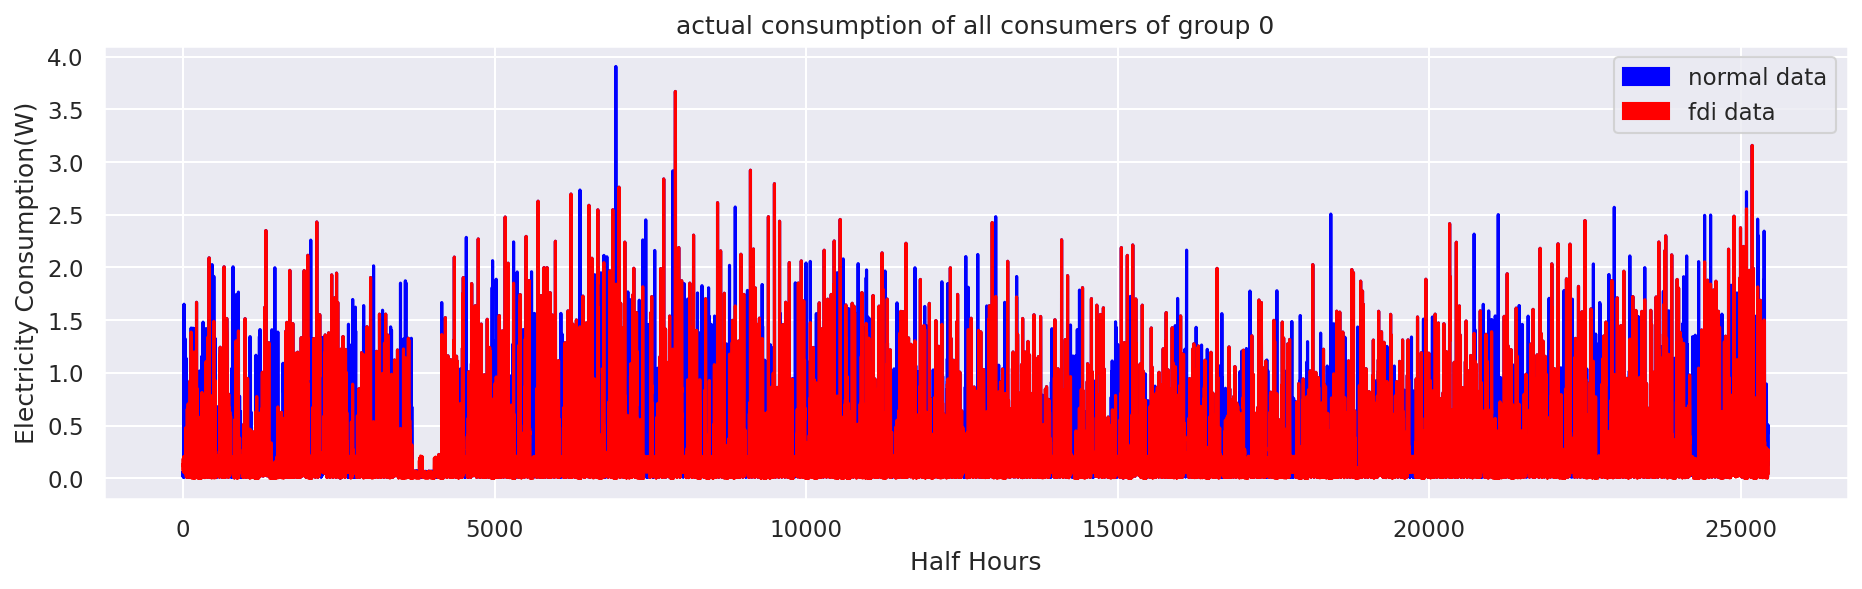

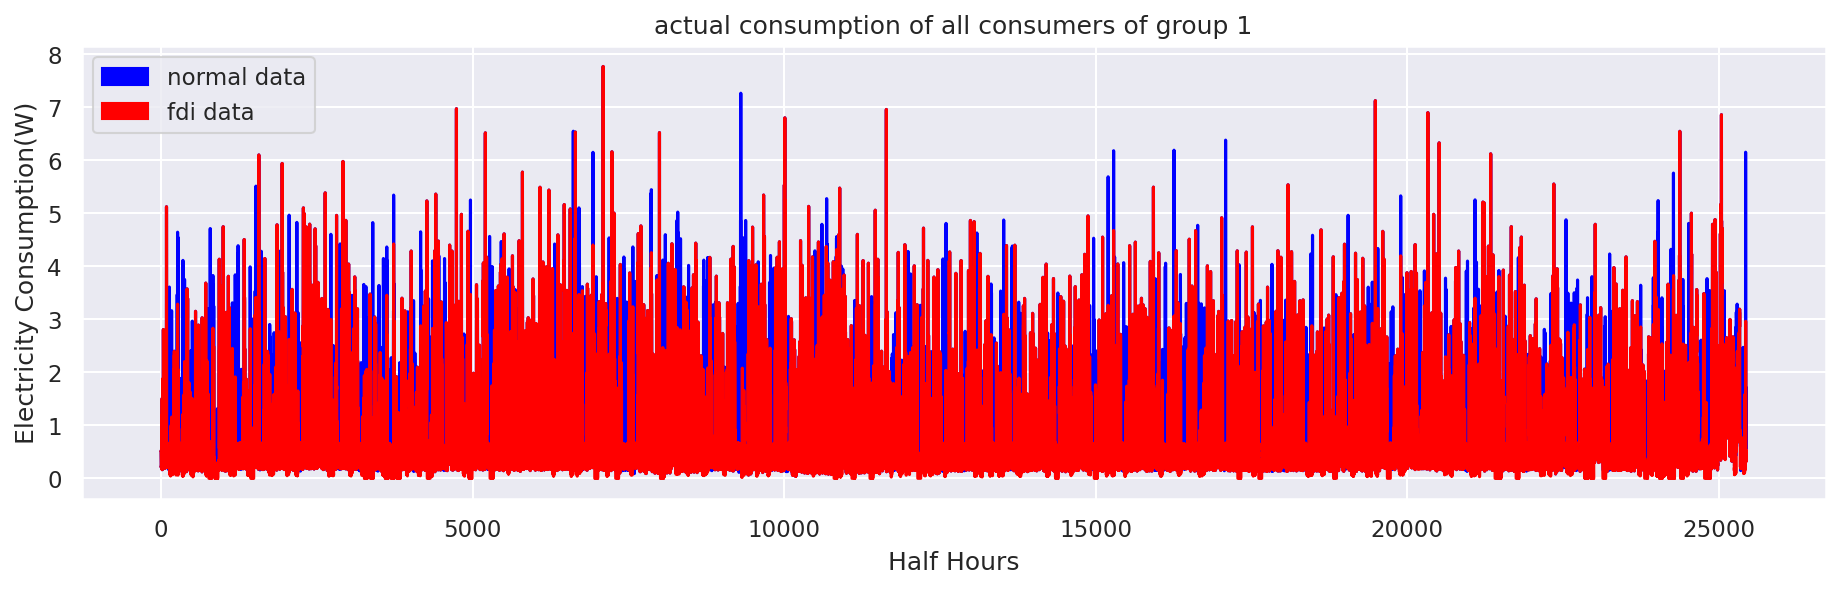

In [11]:
for i in range(len(final_data_group)):
    if i == 2: break
    plot_data(origin_data_group[i]["fdi"], final_data_group[i]["fdi"], "actual consumption of all consumers of group " + str(i), "normal data", "fdi data", plot_house=1, plot_hour=NUMBER_OF_HALF_HOURS, save=False)

## Check NTL

In [63]:
# observe_meter_data_group = copy.deepcopy(origin_data_group) ## data without fdi
# smart_meter_data_group = copy.deepcopy(final_data_group) ## data with fdi
observe_meter_data_group = origin_data_group ## data without fdi
smart_meter_data_group = final_data_group ## data with fdi

NameError: name 'final_data_group' is not defined

In [ ]:
# calculate NTL loss vector for every day
ntl_loss_data_group = []
for observe_area, smart_area in zip(observe_meter_data_group, smart_meter_data_group): # iterate 10 area
    ntl_loss_data = []
    for observe_meter, smart_meter in zip(observe_area['fdi'], smart_area['fdi']): #iterate fdi meter in each area
        
        sub = observe_meter[["Electricity"]] - smart_meter[["Electricity"]]

        ntl_loss_data = sub.to_numpy().reshape(NUMBER_OF_DAYS, 48) 

    ntl_loss_data_group.append(ntl_loss_data)
ntl_loss_data_group = np.asarray(ntl_loss_data_group)
ntl_loss_data_group.shape

In [ ]:
# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

In [19]:
print(type(smart_meter_data_group[0]["normal"]))
len(smart_meter_data_group[1]["normal"])

<class 'list'>


380

### write observe meter data

In [64]:
# smart meter to csv
observe_meter_list = []
observe_meter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI','Electricity'])
pbar = tqdm(observe_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        meter['FDI']='True'
        observe_meter_list.append(meter.to_numpy())
    for meter in area['normal']:
        meter['FDI']='False'
        observe_meter_list.append(meter.to_numpy())
#             se = {'MeterID': meter_id, 'Day': meter_day,'FDI':True }
#             v_value_list.append(se)

  0%|          | 0/10 [00:00<?, ?it/s]

In [65]:
# uncomment the code below to save preprocessed data into smart_meter.csv file.
df = pd.DataFrame(np.array(observe_meter_list).reshape(-1, 6), columns=["MeterID","Day","Time","Electricity","Datetime", "FDI"])
df.head()
df = df[["MeterID","Day","Time","Electricity","FDI"]]
e = df.to_csv(index=False)
f = open('CSV/observe_meter.csv','w')
f.write(e) #Give your csv text here.
f.close()

### write smart meter data

In [15]:
# smart meter to csv
smart_meter_list = []
smart_meter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI','Electricity'])
pbar = tqdm(smart_meter_data_group) 
for area in pbar: # iterate 10 data groups
    for meter in area['fdi']: # iterate every fdi meter in area 
        meter['FDI']='True'
        smart_meter_list.append(meter.to_numpy())
    for meter in area['normal']:
        meter['FDI']='False'
        smart_meter_list.append(meter.to_numpy())
#             se = {'MeterID': meter_id, 'Day': meter_day,'FDI':True }
#             v_value_list.append(se)

  0%|          | 0/10 [00:00<?, ?it/s]

In [16]:
# uncomment the code below to save preprocessed data into smart_meter.csv file.
df = pd.DataFrame(np.array(smart_meter_list).reshape(-1, 6), columns=["MeterID","Day","Time","Electricity","Datetime", "FDI"])
df.head()
df = df[["MeterID","Day","Time","Electricity","FDI"]]
e = df.to_csv(index=False)
f = open('CSV/smart_meter.csv','w')
f.write(e) #Give your csv text here.
f.close()

# 3. Featrue extraction

### read smart meter data

In [5]:
smart_meter_data_group = read_smart_meter_csv()

start area  0
start area  1
start area  2
start area  3
start area  4
start area  5
start area  6
start area  7
start area  8
start area  9


In [6]:
for i in smart_meter_data_group[0]['normal'][:3]:
    print(i['Electricity'].max())

9.741
7.651
6.23


## V-Value

### Normalization

In [29]:
# the value of x is divided by its
# maximum and scaled into a value between zero and one
# normalized smart_meter_data_group by divide the max eletricity of the meter
for area in smart_meter_data_group:
    for meter in area['fdi']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
    for meter in area['normal']:
        meter_numpy = meter['Electricity'].to_numpy()
        meter['Electricity'] = meter_numpy / meter_numpy.max()
smart_meter_data_group[0]['fdi'][0]['Electricity'].to_numpy()

array([0.03654133667327904, 0.03531269191667239, 0.030966420614507387,
       ..., 0.04361966398335228, 0.03120148357601003,
       0.011117897020210493], dtype=object)

Series([], Name: Electricity, dtype: int64)


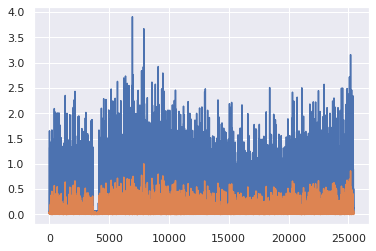

In [30]:
# make sure there is difference between the observe_meter_data_group and smart_meter_data_group
plt.plot(observe_meter_data_group[0]["fdi"][0]["Electricity"].tolist())
plt.plot(smart_meter_data_group[0]["fdi"][0]["Electricity"].tolist()) 
for j in range(1):
    t = observe_meter_data_group[0]["fdi"][j]["Electricity"] - smart_meter_data_group[0]["fdi"][j]["Electricity"]
    print(t.value_counts())

### calculate v-value

In [39]:
v_value_list = v_value(smart_meter_data_group, NUMBER_OF_DAYS)

  0%|          | 0/10 [00:00<?, ?it/s]

finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal
finish fdi
finish normal


In [40]:
df = pd.DataFrame(v_value_list)
df.head()

MeterID         Day   FDI  Tmax1  Tmax2  Tmin1     Cmax1     Cmax2     Cmin1
0     1236  2009-07-15  True     12     30     15  0.205161  0.209875  0.059876
1     1236  2009-07-16  True     20     34     24  0.656000  0.706000  0.012000
2     1236  2009-07-17  True     18     35     24  0.925000  1.387000  0.020000
3     1236  2009-07-18  True      0     35      0  0.000000  1.198190  0.000000
4     1236  2009-07-19  True     25     36     29  1.669000  0.850000  0.090000

In [41]:
e = df.to_csv(index=False)
f = open('CSV/v_value.csv','w')
f.write(e) #Give your csv text here.
## Python will convert \n to os.linesep
f.close()

In [42]:
for i in df.columns:
    print(f"{'-'*5} {i} {'-'*5}")
    print(df[i].value_counts())

----- MeterID -----
2049    530
5425    530
1323    530
1324    530
3373    530
       ... 
6857    530
6856    530
4809    530
2765    530
2047    530
Name: MeterID, Length: 4225, dtype: int64
----- Day -----
2010-01-07    4225
2009-07-26    4225
2010-08-28    4225
2009-11-05    4225
2010-05-13    4225
              ... 
2009-12-16    4225
2010-10-02    4225
2010-04-05    4225
2010-03-27    4225
2009-11-28    4225
Name: Day, Length: 530, dtype: int64
----- FDI -----
False    2016650
True      222600
Name: FDI, dtype: int64
----- Tmax1 -----
27    147105
26    144821
25    144026
16    141864
15    137091
17    131010
24    129038
18    127262
19    124185
20    121665
21    118484
23    116439
22    115951
0     115939
14    104604
13     60005
1      47532
12     38634
2      29681
11     24369
3      20980
4      16783
10     15860
5      14166
9      13849
6      12995
8      12849
7      12063
Name: Tmax1, dtype: int64
----- Tmax2 -----
35    176169
36    172672
37    154810
34   

In [ ]:
del meter_day
del meter_id
del meter_numpy
del e
del f
del df
gc.collect()

##  four time interval

1) Time Period 1: 10.30 P.M.–6.30 A.M.—overnight period (45:14) 17  
2) Time Period 2: 6.30–9.00 A.M.—breakfast period (14:18) 4  
3) Time Period 3: 9.00 A.M.–3.30 P.M.—daytime period (18:31) 14   
4) Time Period 4: 3.30–10.30 P.M.—evening period.(31:45) 14

In [35]:
four_time_list = four_time(smart_meter_data_group, NUMBER_OF_DAYS)

  0%|          | 0/10 [00:00<?, ?it/s]

1


In [36]:
df = pd.DataFrame(four_time_list)
df.head(), df.shape

(   MeterID         Day   FDI  overnight  breakfast   daytime   evening
 0     1236  2009-07-15  True   0.128520    0.06780  0.120048  0.119347
 1     1236  2009-07-16  True   0.084015    0.23875  0.201571  0.196692
 2     1236  2009-07-17  True   0.135647    0.17500  0.231000  0.408409
 3     1236  2009-07-18  True   0.083588    0.00000  0.000000  0.092168
 4     1236  2009-07-19  True   0.029882    0.24775  0.295500  0.250308,
 (223660, 7))

In [37]:
e = df.to_csv(index=False)
f = open('CSV/four_time.csv','w')
f.write(e) #Give your csv text here.
f.close()

In [38]:
temp = pd.read_csv('CSV/four_time.csv')
temp.shape

(223660, 7)

## TS barycenter

### Generate file below

one_cluster_softdtw_barycenter_24hours  
one_cluster_euclidean_barycenter_48hours  
one_cluster_dba_barycenter_48   
one_cluster_sdtw_barycenter_48  

In [ ]:
global center

def km_cluster(train_data, cluster_num, method="EU"):
    if method == "EU":
        eu_km = TimeSeriesKMeans(n_clusters=cluster_num, verbose=False, random_state=42)
        y_pred = eu_km.fit_predict(train_data)
        result = eu_km

    elif method == "DBA":
        dba_km = TimeSeriesKMeans(n_clusters=cluster_num,
                              n_init=2,
                              metric="dtw",
                              verbose=False,
                              max_iter_barycenter=10,
                              random_state=42)

        y_pred = dba_km.fit_predict(train_data)
        result = dba_km

    
    elif method == "Soft-DTW":
        sdtw_km = TimeSeriesKMeans(n_clusters=cluster_num,
                           metric="softdtw",
                           metric_params={"gamma": .01},
                           verbose=True  ,
                           random_state=42,
                            n_jobs=-1)
        y_pred = sdtw_km.fit_predict(train_data)
        result = sdtw_km
        
    plt.figure(dpi=80, figsize=(15,4))
    for yi in range(cluster_num):
        plt.subplot(2, 3, yi+1)
        for xx in train_data[y_pred == yi]:
            plt.plot(xx.ravel(), "k-", alpha=.2)
            if method == "EU":
                plt.plot(eu_km.cluster_centers_[yi].ravel(), "r-")
            elif method == "DBA":
                plt.plot(dba_km.cluster_centers_[yi].ravel(), "r-")
            elif method == "Soft-DTW":
                plt.plot(sdtw_km.cluster_centers_[yi].ravel(), "r-")
                
        plt.xlim(0, train_data.shape[0])
    #     plt.ylim(-4, 4)
        plt.text(0.55, 0.85,'Cluster %d' % (yi + 1),
                 transform=plt.gca().transAxes)
        if yi == 1:
            plt.title(method+"$k$-means")
    plt.show()
            
    return y_pred, result

### barycenter sdtw 24

In [ ]:
SDTW_result = {}
method = "Soft-DTW"
# barycenter_df = pd.DataFrame(columns=['MeterID', 'Day', 'FDI', 'overnight', 'breakfast', 'daytime', 'evening'])
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    y_pred, result = km_cluster(X, 1, method)
    SDTW_result[count] = (y_pred, result, result.cluster_centers_, Y)
    count = count + 1

In [ ]:
#save model
one_cluster_sdtw_barycenter = []
for i in range(len(SDTW_result)):
    i = i + 1
    one_cluster_sdtw_barycenter.append(SDTW_result[i][2])
df = pd.DataFrame(one_cluster_sdtw_barycenter[0].reshape(-1, 24))
df.head(), df.shape
e = df.to_csv(index=False)
f = open('one_cluster_softdtw_barycenter_24hours.csv','w')
f.write(e) #Give your csv text here.
f.close()

### barycenter euclidean 48

In [ ]:
euclidean_barycenter_result = {}
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    print(f'start {count}')
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    result = euclidean_barycenter(X)
    euclidean_barycenter_result[count] = (result, Y)
    count = count + 1
    
one_cluster_euclidean_barycenter_48 = []
for i in range(len(euclidean_barycenter_result)):
    i = i + 1
    one_cluster_euclidean_barycenter_48.append(euclidean_barycenter_result[i][0])

In [ ]:
df = pd.DataFrame(np.array(one_cluster_euclidean_barycenter_48).reshape(10, 530*48))
df.shape

In [ ]:
e = df.to_csv(index=False)
f = open('one_cluster_euclidean_barycenter_48hours.csv','w')
f.write(e) #Give your csv text here.
f.close()

#### barycenter euclidean 48 training

In [ ]:
for i in one_cluster_euclidean_barycenter_48[1]:
    plt.plot(i)

In [ ]:
def calc_stuff(x,y):   # these are examples.
    meter_euclid = np.linalg.norm(x-y)
    meter_dtw = dtw(x,y)
    meter_sdtw = soft_dtw(x,y)
    return meter_euclid, meter_dtw, meter_sdtw

def procedure(j):                 # just factoring out the
    df_list = []
    d = j.reshape(-1, 5)
    meter = pd.DataFrame(d, columns=["MeterID","Day","Time","Electricity","FDI"])
    day_list = meter['Day'].reset_index()
    for i in range(530): # 
        
        meter_id = meter["MeterID"].loc[0]
        meter_day = day_list['Day'][i*48]
        meter_fdi = meter["FDI"].loc[0]
        x = meter["Electricity"].to_numpy()[i*48:(i+1)*48]
        y = center[i*48:(i+1)*48]
#         if i == 529:
#             print(f'meter_id : {meter_id} , x.shape :{ x.shape}, y.shape: {y.shape},{i*48,(i+1)*48}')
        meter_euclid, meter_dtw, meter_sdtw = calc_stuff(x,y)
        se = {'MeterID': meter_id, 'Day': meter_day,'FDI': meter_fdi, "meter_euclid": meter_euclid, "meter_dtw":meter_dtw, "meter_sdtw":meter_sdtw}
        df_list.append(se)
    return df_list

def main(PoolExecutor, area_num): # take ProcessPoolExecutor or ThreadPoolExecutor
    
    inputs = data_group[area_num] # data_group[0] 有422個
    output1 = list()

    start = time()           # let's see how long this takes
    
    with PoolExecutor() as executor:
        for out1 in executor.map(procedure, inputs):
            # put results into correct output list:
            output1.append(out1)
            
    finish = time()
    print(f'PoolExecutor: {PoolExecutor}')
    print(f'time : {(finish-start)}')
    return output1

In [ ]:
center_euclid_48 = pd.read_csv('one_cluster_euclidean_barycenter_48hours.csv')
center_euclid_48.shape

In [ ]:
euclid_day_score_list = []
for num in range(10):
    print(f'start area {num}')
    center = center_euclid_48.loc[num].to_numpy()
    sdtwa = main(ProcessPoolExecutor, num)
    euclid_day_score_list.append(sdtwa)

In [ ]:
score_list = []
area_count = 0
meter_count = 0
day_count = 0

for index, area in enumerate(euclid_day_score_list): # area=10
    area_count += 1
    for meter in area: #meter=422(427)
        meter_count += 1
        for day in meter:
            day_count +=1
            score_list.append(day)
area_count, meter_count, day_count

In [ ]:
euclid_day_score_df = pd.DataFrame(score_list)
df = euclid_day_score_df
X = df[["meter_euclid"]]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

In [ ]:
model = XGBClassifier()
# define grid
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000, 116,  10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train, verbose=True)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### barycenter dba 48

In [42]:
# calculate center
dba_barycenter_result = {}
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    print(f'start {count}')
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    result = dtw_barycenter_averaging_subgradient(X, max_iter=20, tol=1e-3)
    dba_barycenter_result[count] = (result, Y)
    count = count + 1
    
one_cluster_dba_barycenter_48 = []
for i in range(len(dba_barycenter_result)):
    i = i + 1
    one_cluster_dba_barycenter_48.append(dba_barycenter_result[i][0])
print(one_cluster_dba_barycenter_48[9].shape)

  0%|          | 0/10 [00:00<?, ?it/s]

start 1
(422, 25440)
(422, 530, 48)


KeyboardInterrupt: 

In [ ]:
for i in one_cluster_dba_barycenter_48[0][:10]:
    plt.plot(i)
#     break

In [ ]:
# df = pd.DataFrame(np.array(one_cluster_dba_barycenter_48).reshape(10, 530*48))
# print(df.shape)
# e = df.to_csv(index=False)
# f = open('one_cluster_dba_barycenter_48.csv','w')
# f.write(e) #Give your csv text here.
# f.close()

#### barycenter dba 48 training

In [ ]:
def calc_stuff(x,y):   # these are examples.
    meter_euclid = np.linalg.norm(x-y)
    meter_dtw = dtw(x,y)
    meter_sdtw = soft_dtw(x,y)
    return meter_euclid, meter_dtw, meter_sdtw

def procedure(j):                 # just factoring out the
    df_list = []
    d = j.reshape(-1, 5)
    meter = pd.DataFrame(d, columns=["MeterID","Day","Time","Electricity","FDI"])
    day_list = meter['Day'].reset_index()
    for i in range(530): # 
        
        meter_id = meter["MeterID"].loc[0]
        meter_day = day_list['Day'][i*48]
        meter_fdi = meter["FDI"].loc[0]
        x = meter["Electricity"].to_numpy()[i*48:(i+1)*48]
        y = center[i*48:(i+1)*48]
#         if i == 529:
#             print(f'meter_id : {meter_id} , x.shape :{ x.shape}, y.shape: {y.shape},{i*48,(i+1)*48}')
        meter_euclid, meter_dtw, meter_sdtw = calc_stuff(x,y)
        se = {'MeterID': meter_id, 'Day': meter_day,'FDI': meter_fdi, "meter_euclid": meter_euclid, "meter_dtw":meter_dtw, "meter_sdtw":meter_sdtw}
        df_list.append(se)
    return df_list

def main(PoolExecutor, area_num): # take ProcessPoolExecutor or ThreadPoolExecutor
    
    inputs = data_group[area_num] # data_group[0] 有422個
    output1 = list()

    start = time()           # let's see how long this takes
    
    with PoolExecutor() as executor:
        for out1 in executor.map(procedure, inputs):
            # put results into correct output list:
            output1.append(out1)
            
    finish = time()
    print(f'PoolExecutor: {PoolExecutor}')
    print(f'time : {(finish-start)}')
    return output1

In [ ]:
center_dba_48 = pd.read_csv('one_cluster_dba_barycenter_48.csv')
center_dba_48.shape

In [ ]:
dba_day_score_list = []
for num in range(10):
    print(f'start area {num}')
    center = center_dba_48.loc[num].to_numpy()
    sdtwa = main(ProcessPoolExecutor, num)
    dba_day_score_list.append(sdtwa)

In [ ]:
# combime score list
score_list = []
area_count = 0
meter_count = 0
day_count = 0
dba_day_score_df = pd.DataFrame(columns=["MeterID", "Day", "FDI", "meter_dtw", "meter_sdtw"])
for index, area in enumerate(dba_day_score_list): # area=10
    area_count += 1
    for meter in area: #meter=422(427)
        meter_count += 1
        for day in meter:
            day_count +=1
            score_list.append(day)
area_count, meter_count, day_count

In [ ]:
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

In [ ]:
dba_day_score_df = pd.DataFrame(score_list)
df = dba_day_score_df
X = df[["meter_dtw"]]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250


X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]

model = XGBClassifier()
# define grid
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000, 116,  10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train, verbose=True)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### barycenter sdtw 48

In [45]:
barycenter_result = {}
pbar = tqdm(smart_meter_data_group)
count = 1
for area in pbar: # iterate 10 data groups
    print(f'start {count}')
    X = []
    Y = []
    for meter in area['fdi']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'True'))
    for meter in area['normal']: # iterate every fdi meter in area 
        X.append(meter["Electricity"].to_numpy())
        Y.append((meter["MeterID"].max(), 'False'))
    X = np.array(X)
    print(X.shape)
    Y = np.array(Y)
    X = X.reshape(-1, 530, 48 )
    print(X.shape)
    result = softdtw_barycenter(X, max_iter=5, gamma=1.)
    barycenter_result[count] = (result, Y)
    count = count + 1
one_cluster_sdtw_barycenter_48 = []
for i in range(len(barycenter_result)):
    i = i + 1
    one_cluster_sdtw_barycenter_48.append(barycenter_result[i][0])
one_cluster_sdtw_barycenter_48[0].shape

  0%|          | 0/10 [00:00<?, ?it/s]

start 1
(422, 25440)
(422, 530, 48)
start 2
(422, 25440)
(422, 530, 48)


KeyboardInterrupt: 

In [ ]:
for i in one_cluster_sdtw_barycenter_48[0]:
    plt.title("Every day's barycenter in first area")
    plt.xlabel("Half hours")
    plt.ylabel("Soft-dtw barycenter")
    plt.plot(i)
save_fig("Barycenter of each day in the first area")

In [ ]:
for i in one_cluster_sdtw_barycenter_48[0]:
    plt.plot(i)

In [ ]:
df = pd.DataFrame(np.array(one_cluster_sdtw_barycenter_48).reshape(10, 530*48))
df.shape

In [ ]:
e = df.to_csv(index=False)
f = open('one_cluster_sdtw_barycenter_48.csv','w')
f.write(e) #Give your csv text here.
f.close()

#### barycenter sdtw 48 training

In [ ]:
center_sdtw_48 = pd.read_csv('one_cluster_sdtw_barycenter_48.csv')
center_sdtw_48.shape

In [ ]:
sdtw_day_score_list = []
for num in range(10):
    print(f'start area {num}')
    center = center_sdtw_48.loc[num].to_numpy()
    sdtwa = main(ProcessPoolExecutor, num)
    sdtw_day_score_list.append(sdtwa)

In [ ]:
# combime score list
score_list = []
area_count = 0
meter_count = 0
day_count = 0
sdtw_day_score_list = pd.DataFrame(columns=["MeterID", "Day", "FDI", "meter_dtw", "meter_sdtw"])
for index, area in enumerate(sdtw_day_score_list): # area=10
    area_count += 1
    for meter in area: #meter=422(427)
        meter_count += 1
        for day in meter:
            day_count +=1
            score_list.append(day)
area_count, meter_count, day_count

In [ ]:
sdtw_day_score_list = pd.DataFrame(score_list)
df = sdtw_day_score_list
X = df[["meter_dtw"]]
Y = df[["FDI"]]

partition = 422*8*530
evaluation = 422*1*530
total = 2239250

print(X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape)

X_train = X[:partition]
X_val = X[partition:total-evaluation]
X_test = X[total-evaluation: total]
y_train = Y[:partition]
y_val = Y[partition:total-evaluation]
y_test = Y[total-evaluation: total]

model = XGBClassifier()
# define grid
weights = [0.01, 0.1, 1, 10, 25, 50, 75, 99, 100, 1000, 116,  10.7]
param_grid = dict(scale_pos_weight=weights)
# define evaluation procedure
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
# define grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=cv, scoring='roc_auc')
# execute the grid search
grid_result = grid.fit(X_train, y_train, verbose=True)
# report the best configuration
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
# report all configurations
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

### Final sdtw day score calculating

#### using 10 * 48 sdtw

In [7]:
center_sdtw = pd.read_csv('CSV/tsc/one_cluster_sdtw_barycenter.csv')
print(center_sdtw.shape)

smart_meter_df = pd.read_csv('CSV/smart_meter.csv')
print(smart_meter_df.shape)

(10, 48)
(107484000, 5)


In [8]:
n = np.array(smart_meter_df['Electricity'])
nr = n.reshape(-1, 530, 48, 1)
print("nr.shape: ", nr.shape)

data_group = {}
for i in range(10):
    if i == 9:
        data_group[i] = nr[4225-427: 4225].reshape(-1, 530, 48)
    else:
        data_group[i] = nr[i*422:(i+1)*422].reshape(-1, 530, 48)
print("data_group[0][0][0].shape: ", data_group[0][0][0].shape)
print(data_group[0].shape)

nr.shape:  (4225, 530, 48, 1)
data_group[0][0][0].shape:  (48,)
(422, 530, 48)


In [11]:
def calc_stuff(x,y):   # calc dtw and sdtw between x and y 
    meter_dtw = dtw(x,y)
    meter_sdtw = soft_dtw(x,y)
    return meter_dtw, meter_sdtw

def procedure(area_data):                 # just factoring out the
    df_list = []
    
    for i in range(530): # iterate every day for each user
        
        
        x = area_data[i]
        y = center
        print(y)
        meter_dtw, meter_sdtw = calc_stuff(x,y)
        se = {"meter_dtw":meter_dtw, "meter_sdtw":meter_sdtw}
        df_list.append(se)    
    return df_list

def main(PoolExecutor, area_num): # take ProcessPoolExecutor or ThreadPoolExecutor
    
    inputs = data_group[area_num] # data_group[0] 有422個
    output1 = list()

    start = time()           # let's see how long this takes
    
    with PoolExecutor() as executor:
        for out1 in executor.map(procedure, inputs): #iterate 422 users in each area
            # put results into correct output list:
            output1.append(out1)
            
    finish = time()
    print(f'PoolExecutor: {PoolExecutor}')
    print(f'time : {(finish-start)}')
    return output1

In [10]:
sdtw_day_score_list = []
for area in range(10): #iter 10 area
    print(f'start area {area}')
    center = center_sdtw.iloc[area].to_numpy()
    sdtw_temp = main(ProcessPoolExecutor, area)
    sdtw_day_score_list.append(sdtw_temp)

start area 0
[0.54657957 0.28922521 0.24800499 0.22420908 0.20933082 0.19997395
 0.19436095 0.19172163 0.19156306 0.19359103 0.19799834 0.20500539
 0.21484785 0.22765341 0.2430915  0.26068419 0.28014836 0.30021529
 0.3182198  0.33127211 0.3376995  0.33851627 0.33614842 0.33239407
 0.32873584 0.32582216 0.32295344 0.32082812 0.32087544 0.32415688
 0.33189268 0.34602787 0.37009989 0.41119512 0.48864445 0.69065013
 2.05741718 0.81716723 0.62444931 0.57292458 0.55044253 0.55128956
 0.56410809 0.58241957 0.59582272 0.58926679 0.56261874 0.54399193][0.54657957 0.28922521 0.24800499 0.22420908 0.20933082 0.19997395
 0.19436095 0.19172163 0.19156306 0.19359103 0.19799834 0.20500539
 0.21484785 0.22765341 0.2430915  0.26068419 0.28014836 0.30021529
 0.3182198  0.33127211 0.3376995  0.33851627 0.33614842 0.33239407
 0.32873584 0.32582216 0.32295344 0.32082812 0.32087544 0.32415688
 0.33189268 0.34602787 0.37009989 0.41119512 0.48864445 0.69065013
 2.05741718 0.81716723 0.62444931 0.57292458 0.55

In [37]:
sdtw_temp = []
for i in range(len(sdtw_day_score_list)):
    sdtw_temp.append(sdtw_day_score_list[i])

In [49]:
print(len(sdtw_day_score_list))
print(len(sdtw_day_score_list[0]))
print(len(sdtw_day_score_list[0][0]))
print(len(sdtw_day_score_list[0][0][0]))

10
422
530
2


In [50]:
score_list = []
area_count = 0
meter_count = 0
day_count = 0

for index, area in enumerate(sdtw_day_score_list): # area=10
    area_count += 1
    for meter in area: #meter=422(427)
        meter_count += 1
        for day in meter:
            day_count +=1
            score_list.append(day)
print(area_count, meter_count, day_count)

10 4225 2239250


In [52]:
sdtw_day_score_df = pd.DataFrame(score_list)
e = sdtw_day_score_df.to_csv(index=False)
f = open('tsc_dtw_sdtw_10*48.csv','w')
f.write(e) #Give your csv text here.
f.close()

#### using 10 * 530 * 48 sdtw

In [12]:
center_sdtw = pd.read_csv('CSV/tsc/one_cluster_sdtw_barycenter_48.csv')
print(center_sdtw.shape)

smart_meter_df = pd.read_csv('CSV/smart_meter.csv')
print(smart_meter_df.shape)

(10, 25440)
(107484000, 5)


In [13]:
n = np.array(smart_meter_df['Electricity'])
nr = n.reshape(-1, 530, 48, 1)
print("nr.shape: ", nr.shape)

nr.shape:  (4225, 530, 48, 1)


In [14]:
data_group = {}
for i in range(10):
    if i == 9:
        data_group[i] = nr[4225-427: 4225].reshape(-1, 530, 48)
    else:
        data_group[i] = nr[i*422:(i+1)*422].reshape(-1, 530, 48)
print("data_group[0][0][0].shape: ", data_group[0][0][0].shape)
print(data_group[0].shape)

data_group[0][0][0].shape:  (48,)
(422, 530, 48)


In [24]:
def calc_stuff(x,y):   # calc dtw and sdtw between x and y 
    meter_dtw = dtw(x,y)
    meter_sdtw = soft_dtw(x,y)
    return meter_dtw, meter_sdtw

def procedure(area_data):                 # just factoring out the
    df_list = []
    
    for i in range(530): # iterate every day for each user
        x = area_data[i]
        y = center[i*48:(i+1)*48]
        meter_dtw, meter_sdtw = calc_stuff(x,y)
        se = {"meter_dtw":meter_dtw, "meter_sdtw":meter_sdtw}
        df_list.append(se)    
    return df_list

def main(PoolExecutor, area_num): # take ProcessPoolExecutor or ThreadPoolExecutor
    
    inputs = data_group[area_num] # data_group[0] 有422個
    output1 = list()

    start = time()           # let's see how long this takes
    
    with PoolExecutor() as executor:
        for out1 in executor.map(procedure, inputs): #iterate 422 users in each area
            # put results into correct output list:
            output1.append(out1)
            
    finish = time()
    print(f'PoolExecutor: {PoolExecutor}')
    print(f'time : {(finish-start)}')
    return output1

In [26]:
sdtw_day_score_list = []
for area in range(10): #iter 10 area
    print(f'start area {area}')
    center = center_sdtw.iloc[area].to_numpy()
    sdtw_temp = main(ProcessPoolExecutor, area)
    sdtw_day_score_list.append(sdtw_temp)

start area 0
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.396644115447998
start area 1
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.371230363845825
start area 2
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.73043704032898
start area 3
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.860711336135864
start area 4
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.803816556930542
start area 5
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.81618881225586
start area 6
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.781157970428467
start area 7
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.821248292922974
start area 8
PoolExecutor: <class 'concurrent.futures.process.ProcessPoolExecutor'>
time : 8.96027159690857
start area 9
PoolExecu

In [27]:
sdtw_temp = []
for i in range(len(sdtw_day_score_list)):
    sdtw_temp.append(sdtw_day_score_list[i])

In [28]:
print(len(sdtw_day_score_list))
print(len(sdtw_day_score_list[0]))
print(len(sdtw_day_score_list[0][0]))
print(len(sdtw_day_score_list[0][0][0]))

10
422
530
2


In [29]:
score_list = []
area_count = 0
meter_count = 0
day_count = 0

for index, area in enumerate(sdtw_day_score_list): # area=10
    area_count += 1
    for meter in area: #meter=422(427)
        meter_count += 1
        for day in meter:
            day_count +=1
            score_list.append(day)
print(area_count, meter_count, day_count)

10 4225 2239250


In [30]:
sdtw_day_score_df = pd.DataFrame(score_list)
e = sdtw_day_score_df.to_csv(index=False)
f = open('tsc_dtw_sdtw_10*530*48.csv','w')
f.write(e) #Give your csv text here.
f.close()

## MIC

In [43]:
smart_meter_data_group = read_smart_meter_csv()

start area  0
start area  1
start area  2
start area  3
start area  4
start area  5
start area  6
start area  7
start area  8
start area  9


In [32]:
smart_meter_data_mic = []
for area in smart_meter_data_group:
    
    for meter in area['fdi']:
        t = meter['Electricity'].to_numpy().reshape(530, 48)
        smart_meter_data_mic.append(t)
    for meter in area['normal']:
        t = meter['Electricity'].to_numpy().reshape(530, 48)
        smart_meter_data_mic.append(t)
        
smart_meter_data_mic = np.asarray(smart_meter_data_mic)

In [33]:
smart_meter_data_mic.shape

(4225, 530, 48)

In [34]:
ntl_loss_data_group.shape, ntl_loss_data_group[0].shape

NameError: name 'ntl_loss_data_group' is not defined

In [ ]:
ntl_loss_data_group[0][0]

In [ ]:
# calculate MIC 
m = MINE(alpha=0.8)
mic_result = []
pbar = tqdm(smart_meter_data_group)
# ntl_loss_data_group, smart_meter_data_group

for area_num, area in enumerate(pbar): # iterate 10 data groups
    loss_list = ntl_loss_data_group[area_num]
    for meter in area['fdi']: # iterate every fdi meter in area +
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
#             meter_fdi = meter["FDI"].loc[0]
            u = meter["Electricity"].to_numpy()[i*48:(i+1)*48]
            e = loss_list[i]
            m.compute_score(u, e)
            mic_value = m.mic()
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': True, "mic":round(mic_value, 6)}
            mic_result.append(se)
    for meter in area['normal']:
        day_list = meter['Day'].reset_index()
        for i in range(NUMBER_OF_DAYS): # iterate every day
            meter_id = meter['MeterID'].max()
            meter_day = day_list['Day'][i*48]
#             meter_fdi = meter["FDI"].loc[0]
            u = meter["Electricity"].to_numpy()[i*48:(i+1)*48]
            e = loss_list[i]
            
            m.compute_score(u, e)
            mic_value = m.mic()
            se = {'MeterID': meter_id, 'Day': meter_day,'FDI': False, "mic":mic_value}
            mic_result.append(se)

In [ ]:
mic = pd.DataFrame(mic_result)

In [ ]:
e = mic.to_csv(index=False)
f = open('mic.csv','w')
f.write(e) #Give your csv text here.
## Python will convert \n to os.linesep
f.close()